In [176]:
import pandas
import duckdb

In [177]:
import json

# 1. Open and load the JSON file
with open('config.json', 'r') as f:
    config_data = json.load(f)

# 2. Print it nicely
print("--- CONFIGURATION FILE CONTENT ---")
print(json.dumps(config_data, indent=4))

# 3. Example: Access a specific value
# If your config looks like {"database": {"host": "localhost"}}, you can do:
# print(config_data['database']['host'])

--- CONFIGURATION FILE CONTENT ---
{
    "Channels": {
        "Ambient Temperature": {
            "Frequency": 1,
            "Name": "Ambient Temperature"
        },
        "Brake Pos": {
            "Frequency": 50,
            "Name": "Brake Pos"
        },
        "Brake Pos Unfiltered": {
            "Frequency": 50,
            "Name": "Brake Pos Unfiltered"
        },
        "Brake Tickness": {
            "Frequency": 10,
            "Name": "Brake Tickness"
        },
        "Brakes Force": {
            "Frequency": 50,
            "Name": "Brakes Force"
        },
        "Brakes Temp": {
            "Frequency": 50,
            "Name": "Brakes Temp"
        },
        "Clutch Pos": {
            "Frequency": 50,
            "Name": "Clutch Pos"
        },
        "Clutch Pos Unfiltered": {
            "Frequency": 50,
            "Name": "Clutch Pos Unfiltered"
        },
        "Clutch RPM": {
            "Frequency": 100,
            "Name": "Clutch RPM"
        },


In [178]:

# 1. Connect to your file
con = duckdb.connect('my_data2.duckdb')

# 2. List all tables
print("\n--- TABLES IN DATABASE ---")
tables = con.execute("SHOW TABLES").df()
print(tables.to_string(index=True))




--- TABLES IN DATABASE ---
                          name
0                          ABS
1                     ABSLevel
2          Ambient Temperature
3          AntiStall Activated
4                 Best LapTime
5                 Best Sector1
6                 Best Sector2
7              Brake Bias Rear
8              Brake Migration
9                    Brake Pos
10        Brake Pos Unfiltered
11                Brakes Force
12                 Brakes Temp
13               CloudDarkness
14                  Clutch Pos
15       Clutch Pos Unfiltered
16                  Clutch RPM
17             Current LapTime
18              Current Sector
19             Current Sector1
20             Current Sector2
21                        Drag
22              Engine Max RPM
23             Engine Oil Temp
24                  Engine RPM
25           Engine Water Temp
26                  FFB Output
27               Finish Status
28          Front3rdDeflection
29              FrontDownForce
30         

In [264]:
import duckdb

# Connect to your database
con = duckdb.connect('my_data2.duckdb')

# Query the "Lap" table to find where value becomes 1

query = """
SELECT * FROM "Lap" 
 
LIMIT 100
"""

# Execute and display
df = con.execute(query).df()
print(df)

# Close connection
con.close()

       ts  value
0   39.38      0
1  328.30      1
2  631.58      2


In [196]:
con = duckdb.connect('my_data2.duckdb')

for table_name in tables['name']:
    print(f"\n--- PREVIEW: {table_name} ---")
    
    # FIX: Add double quotes around {table_name} to handle spaces
    # We use single quotes '...' for the f-string so we can use double quotes "..." inside
    print("Schema:")
    schema_df = con.execute(f'DESCRIBE "{table_name}"').df()
    print(schema_df)
    
    print("Data Sample:")
    data_df = con.execute(f'SELECT * FROM "{table_name}" LIMIT 10').df()
    print(data_df)


--- PREVIEW: ABS ---
Schema:
  column_name column_type null   key default extra
0          ts      DOUBLE  YES  None    None  None
1       value     BOOLEAN  YES  None    None  None
Data Sample:
        ts  value
0  39.3800  False
1  70.4825   True
2  70.4925  False
3  71.1575   True
4  71.1675  False
5  71.2225   True
6  71.2325  False
7  71.3075   True
8  71.3175  False
9  72.2875   True

--- PREVIEW: ABSLevel ---
Schema:
  column_name column_type null   key default extra
0          ts      DOUBLE  YES  None    None  None
1       value    UTINYINT  YES  None    None  None
Data Sample:
      ts  value
0  39.38      9

--- PREVIEW: Ambient Temperature ---
Schema:
  column_name column_type null   key default extra
0       value       FLOAT  YES  None    None  None
Data Sample:
       value
0  28.027908
1  28.027908
2  28.027908
3  28.027908
4  28.027908
5  28.027908
6  28.027908
7  28.027908
8  28.027908
9  28.027908

--- PREVIEW: AntiStall Activated ---
Schema:
  column_name column_ty

In [350]:
import pandas as pd
import duckdb
import numpy as np

def get_lap_data_calculated(con, lap_number, channels=['Ground Speed', 'Throttle Pos']):
    """
    Reconstructs lap data.
    Returns DataFrame with: [Time (relative), Lap Dist, ts (absolute), ...channels...]
    """
    
    # ---------------------------------------------------------
    # 1. Setup & Session Stats
    # ---------------------------------------------------------
    # Ensure 'Lap Dist' is in our fetch list, but not duplicated
    target_channels = [c for c in channels if c != 'Lap Dist']
    target_channels.insert(0, 'Lap Dist')

    stats_query = """
        SELECT 
            MIN(value) as start_time,
            MAX(value) as end_time,
            MAX(value) - MIN(value) as duration
        FROM "GPS Time"
    """
    session_stats = con.execute(stats_query).df().iloc[0]
    
    sess_start = session_stats['start_time']
    sess_duration = session_stats['duration']
    
    # ---------------------------------------------------------
    # 2. Get Lap Boundaries & Master Skeleton
    # ---------------------------------------------------------
    lap_times = con.execute(f"SELECT ts FROM Lap WHERE value IN ({lap_number}, {lap_number+1}) ORDER BY value").df()
    
    if lap_times.empty:
        return None

    lap_start = lap_times.iloc[0]['ts']
    lap_end = lap_times.iloc[1]['ts'] if len(lap_times) > 1 else session_stats['end_time']

    # Master Skeleton based on GPS Time
    master_query = f"""
        SELECT value as ts
        FROM "GPS Time"
        WHERE value >= {lap_start} AND value <= {lap_end}
        ORDER BY value
    """
    final_df = con.execute(master_query).df()
    
    # ---------------------------------------------------------
    # 3. Add Relative Time (NEW STEP)
    # ---------------------------------------------------------
    # Simple subtraction: Current Absolute Time - Lap Start Time
    final_df['Time'] = final_df['ts'] - lap_start
    
    # Reorder columns so 'Time' is first
    cols = ['Time', 'ts']
    final_df = final_df[cols]

    # ---------------------------------------------------------
    # 4. Loop Through Channels & Merge
    # ---------------------------------------------------------
    for channel in target_channels:
        try:
            # Get Row Count
            row_count_res = con.execute(f'SELECT COUNT(*) FROM "{channel}"').fetchone()
            if not row_count_res: continue
            row_count = row_count_res[0]
            
            # Calculate Frequency & Indices
            freq = row_count / sess_duration
            start_row_est = int((lap_start - sess_start) * freq)
            end_row_est   = int((lap_end - sess_start) * freq)
            
            buffer = 50
            offset = max(0, start_row_est - buffer)
            limit = (end_row_est - start_row_est) + (buffer * 2)
            
            # Fetch Data
            data_query = f'SELECT value as "{channel}" FROM "{channel}" LIMIT {limit} OFFSET {offset}'
            chan_df = con.execute(data_query).df()
            
            # Reconstruct Time (Absolute)
            global_indices = np.arange(offset, offset + len(chan_df))
            chan_df['ts'] = sess_start + (global_indices / freq)
            
            # Merge
            final_df = pd.merge_asof(final_df, chan_df, on='ts', direction='nearest', tolerance=0.1)
            
        except Exception as e:
            print(f"Error processing channel '{channel}': {e}")
            final_df[channel] = None

    # ---------------------------------------------------------
    # 5. Final Cleanup
    # ---------------------------------------------------------
    if 'Lap Dist' in final_df.columns:
        # 1. Drop the data where the distance sensor reset (Lap N -> Lap N+1 transition)
        dist_diff = final_df['Lap Dist'].diff()
        reset_indices = dist_diff[dist_diff < -100].index
        
        if not reset_indices.empty:
            cutoff_index = reset_indices[0]
            final_df = final_df.loc[:cutoff_index-1]

        # 2. Filter out negative distance (pre-start line jitter)
        final_df = final_df[final_df['Lap Dist'] >= 0]
        
    return final_df

In [365]:
con = duckdb.connect('my_data2.duckdb')
# Define any list of tables you want
my_channels = [
    'Ground Speed', 
    'Throttle Pos', 
    'Brake Pos', 
    'Engine RPM', 
    'Gear',
    'Steered Angle',
    'GPS Latitude',
    'GPS Longitude'
]

# Run it
df = get_lap_data_calculated(con, lap_number=1, channels=my_channels)



In [366]:
df.iloc[0:20]

,Time,ts,Lap Dist,Ground Speed,Throttle Pos,Brake Pos,Engine RPM,Gear,Steered Angle,GPS Latitude,GPS Longitude
0,0.00,328.30,0.001624,167.879166,100.0,0.0,6991.663086,NaN,435.0,60.009586,-0.003339
1,0.01,328.31,0.001624,168.012619,100.0,0.0,6994.246094,NaN,435.0,60.009586,-0.003339
2,0.02,328.32,0.001624,168.147263,100.0,0.0,7000.998535,NaN,435.0,60.009586,-0.003339
3,0.03,328.33,0.001624,168.279541,100.0,0.0,7008.941895,NaN,435.0,60.009586,-0.003339
4,0.04,328.34,0.001624,168.411575,100.0,0.0,7009.383301,NaN,435.0,60.009586,-0.003339
5,0.05,328.35,0.001624,168.540726,100.0,0.0,7009.618652,NaN,435.0,60.009586,-0.003339
6,0.06,328.36,0.001624,168.666290,100.0,0.0,7018.432129,NaN,435.0,60.009586,-0.003339
7,0.07,328.37,0.001624,168.797241,100.0,0.0,7024.089844,NaN,435.0,60.009586,-0.003339
8,0.08,328.38,0.001624,168.924713,100.0,0.0,7031.170898,NaN,435.0,60.009586,-0.003339
9,0.09,328.39,6.254423,169.052399,100.0,0.0,7035.563477,NaN,435.0,60.009628,-0.003333


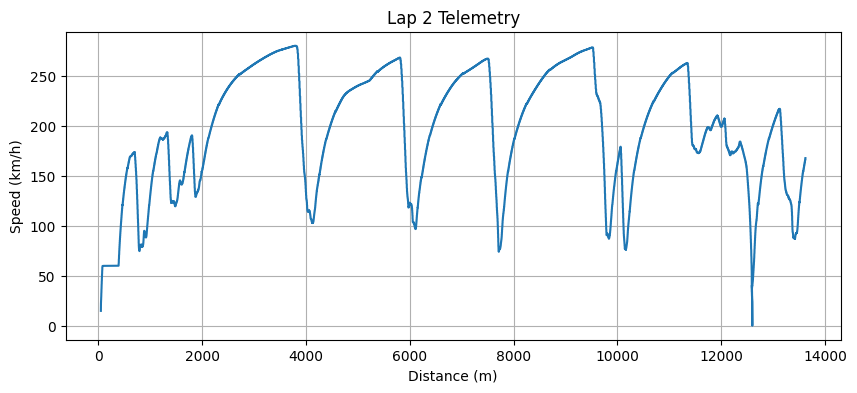

In [345]:
import matplotlib.pyplot as plt

# 1. Fetch Data
channels = ['Ground Speed', 'Throttle Pos', 'Brake Pos', 'Gear']
df = get_lap_data_calculated(con, lap_number=0, channels=channels)

# 2. Plot Speed vs Distance (Standard Race Analysis)
plt.figure(figsize=(10, 4))
plt.plot(df['Lap Dist'], df['Ground Speed'])
plt.xlabel('Distance (m)')
plt.ylabel('Speed (km/h)')
plt.title('Lap 2 Telemetry')
plt.grid(True)
plt.show()

Fetching Lap 0...
Fetching Lap 1...
Fetching Lap 2...


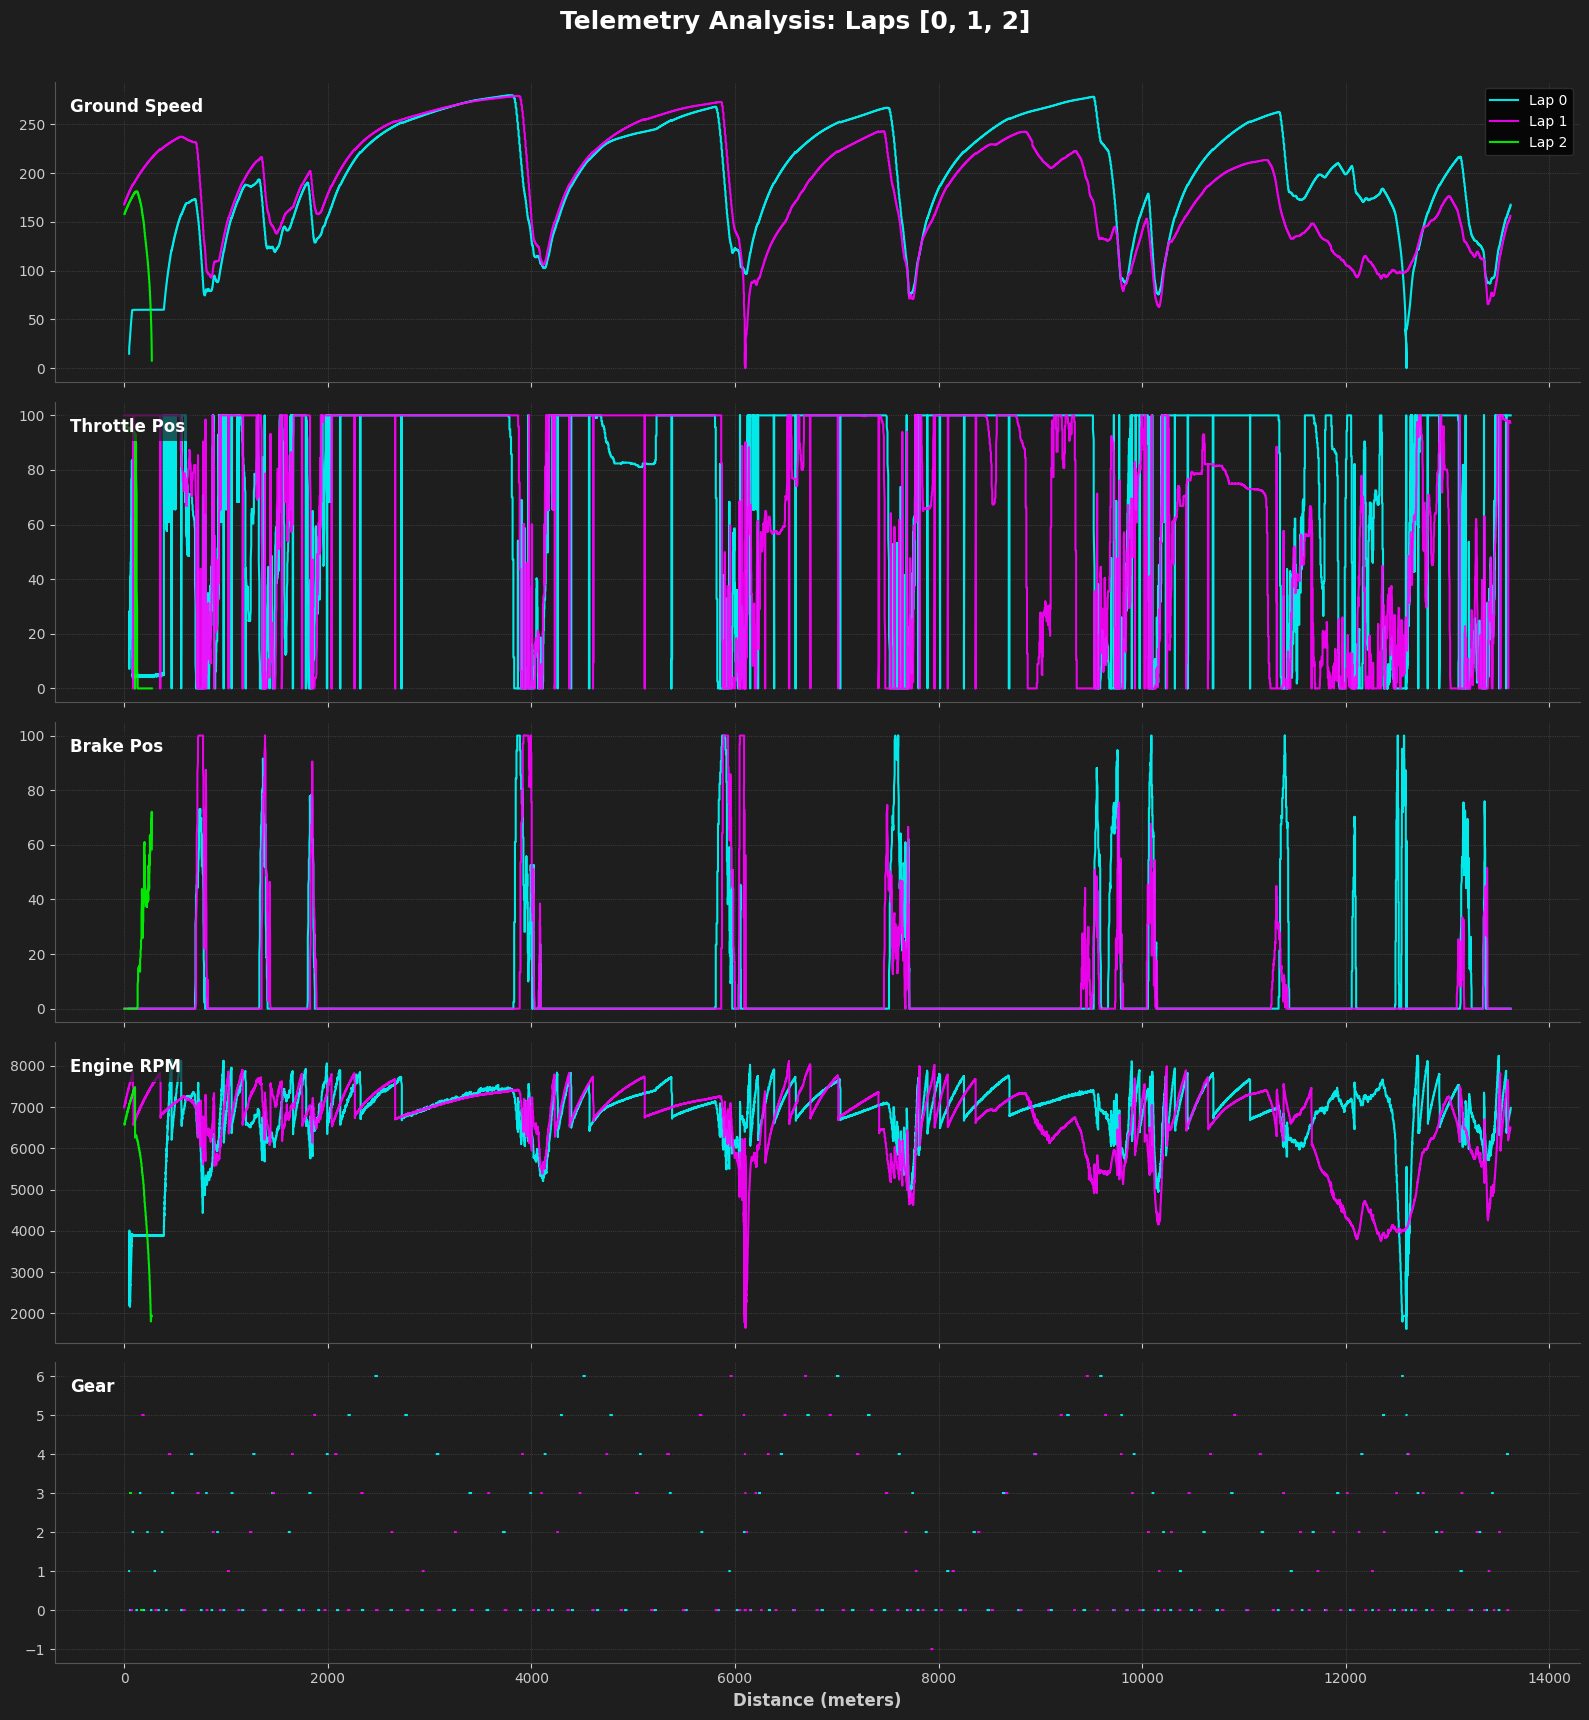

In [349]:
import matplotlib.pyplot as plt
import pandas as pd
import duckdb
import numpy as np

# Apply a dark theme globally
plt.style.use('dark_background')

def plot_telemetry_pro(con, laps=[1, 2, 3], channels=[]):
    """
    Plots telemetry comparisons with a professional 'Dark Mode' aesthetic.
    """
    
    # ---------------------------------------------------------
    # 1. Styling Configuration
    # ---------------------------------------------------------
    # High-contrast "Neon" colors for visibility on dark backgrounds
    # Cyan, Magenta, Lime Green, Yellow, Orange
    lap_colors = ['#00FFFF', '#FF00FF', '#00FF00', '#F1C40F', '#E67E22']
    
    num_channels = len(channels)
    # Increase height slightly for better readability
    fig, axes = plt.subplots(nrows=num_channels, ncols=1, figsize=(16, 3.5 * num_channels), sharex=True)
    
    if num_channels == 1:
        axes = [axes]

    # Background color (slightly lighter than pure black for contrast)
    fig.patch.set_facecolor('#1e1e1e')
    
    # ---------------------------------------------------------
    # 2. Iterate and Plot
    # ---------------------------------------------------------
    for i, lap_num in enumerate(laps):
        print(f"Fetching Lap {lap_num}...")
        df = get_lap_data_calculated(con, lap_number=lap_num, channels=channels)
        
        if df is None or df.empty or 'Lap Dist' not in df.columns:
            continue
            
        label = f"Lap {lap_num}"
        color = lap_colors[i % len(lap_colors)]
        
        for j, channel in enumerate(channels):
            ax = axes[j]
            
            if channel in df.columns:
                # Plot the line
                ax.plot(df['Lap Dist'], df[channel], 
                        label=label, 
                        color=color, 
                        linewidth=1.5, 
                        alpha=0.9) # Slight transparency helps if lines overlap perfectly

    # ---------------------------------------------------------
    # 3. Fine-Tuning the Aesthetics
    # ---------------------------------------------------------
    for j, channel in enumerate(channels):
        ax = axes[j]
        
        # Set chart background color
        ax.set_facecolor('#1e1e1e')
        
        # Channel Title (Inside the plot area to save space, Top-Left)
        ax.text(0.01, 0.9, channel, transform=ax.transAxes, 
                fontsize=12, fontweight='bold', color='white', 
                bbox=dict(facecolor='#1e1e1e', alpha=0.7, edgecolor='none'))
        
        # Grid: Thin, gray, dashed
        ax.grid(True, which='major', linestyle=':', linewidth=0.5, color='#555555')
        
        # Remove top and right borders (Spines) for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('#555555')
        ax.spines['left'].set_color('#555555')
        
        # Tick parameters
        ax.tick_params(axis='x', colors='#cccccc')
        ax.tick_params(axis='y', colors='#cccccc')

    # 4. Legend (Only on the first plot)
    # We make the legend background semi-transparent black
    legend = axes[0].legend(loc='upper right', frameon=True, fontsize=10)
    legend.get_frame().set_facecolor('#000000')
    legend.get_frame().set_edgecolor('#333333')

    # X-Axis Label
    axes[-1].set_xlabel('Distance (meters)', fontsize=12, color='#cccccc', fontweight='bold')
    
    # Main Title
    fig.suptitle(f'Telemetry Analysis: Laps {laps}', fontsize=18, color='white', fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make room for title
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
con = duckdb.connect('my_data2.duckdb')

compare_channels = [
    'Ground Speed', 
    'Throttle Pos', 
    'Brake Pos', 
    'Engine RPM', 
    'Gear',
]

plot_telemetry_pro(con, laps=[0,1, 2], channels=compare_channels)

In [355]:
import numpy as np
import pandas as pd

def calculate_time_delta(df_ref, df_comp):
    """
    Calculates the time difference (Delta) between a comparison lap and a reference lap.
    Returns a dataframe with 'Lap Dist' and 'Delta'.
    
    Formula: Delta = Time_Comp - Time_Ref
    - Positive Delta (> 0): Comparison lap is SLOWER (behind).
    - Negative Delta (< 0): Comparison lap is FASTER (ahead).
    """
    
    # Ensure both dataframes are sorted by distance
    df_ref = df_ref.sort_values('Lap Dist')
    df_comp = df_comp.sort_values('Lap Dist')
    
    # 1. We use the Reference Lap's distance markers as the "Common Grid"
    common_dist = df_ref['Lap Dist'].values
    ref_time = df_ref['Time'].values
    
    # 2. Interpolate the Comparison Lap's time onto these distance markers
    # np.interp(x_new, x_known, y_known)
    comp_time_interp = np.interp(common_dist, df_comp['Lap Dist'].values, df_comp['Time'].values)
    
    # 3. Calculate Delta
    delta = comp_time_interp - ref_time
    
    return pd.DataFrame({
        'Lap Dist': common_dist,
        'Delta': delta
    })

Fetching Lap 0...
Fetching Lap 1...


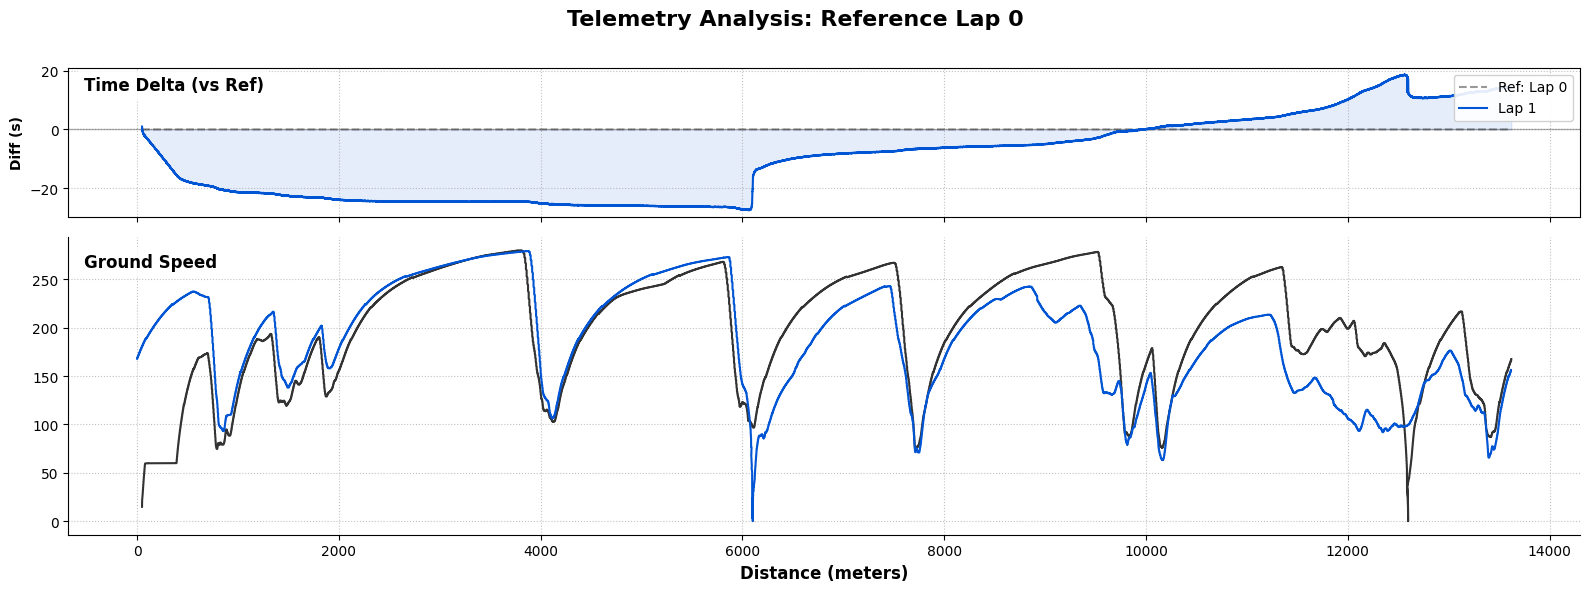

In [362]:
import matplotlib.pyplot as plt
import pandas as pd
import duckdb
import numpy as np

# Reset to default style (White background)
plt.style.use('default')

def plot_telemetry_bright(con, laps=[1, 2], channels=['Ground Speed']):
    """
    Plots telemetry comparisons with a clean, bright 'Light Mode' aesthetic.
    """
    
    # ---------------------------------------------------------
    # 1. Fetch Data
    # ---------------------------------------------------------
    lap_data = {}
    for lap_num in laps:
        print(f"Fetching Lap {lap_num}...")
        df = get_lap_data_calculated(con, lap_number=lap_num, channels=channels)
        if df is not None and not df.empty and 'Lap Dist' in df.columns:
            lap_data[lap_num] = df
        else:
            print(f"  -> Skipping Lap {lap_num} (No data)")

    if not lap_data:
        return

    ref_lap_num = laps[0]
    df_ref = lap_data[ref_lap_num]

    # ---------------------------------------------------------
    # 2. Setup Plot Grid
    # ---------------------------------------------------------
    num_plots = len(channels) + 1
    height_ratios = [1] + [2] * len(channels)
    
    fig, axes = plt.subplots(
        nrows=num_plots, 
        ncols=1, 
        figsize=(16, 3 * num_plots), 
        sharex=True,
        gridspec_kw={'height_ratios': height_ratios}
    )
    
    # Colors for Light Mode (High visibility on white)
    # Ref: Grey/Black, Comp 1: Blue, Comp 2: Red, Comp 3: Green
    lap_colors = ['#333333', '#0055D4', '#D40000', '#009900', '#FF8C00']
    
    # ---------------------------------------------------------
    # 3. Plot Delta (Top Chart)
    # ---------------------------------------------------------
    ax_delta = axes[0]
    ax_delta.set_facecolor('#ffffff') # White background
    ax_delta.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3) # Zero line
    
    # Plot Reference Baseline (Flat line)
    ax_delta.plot(df_ref['Lap Dist'], np.zeros(len(df_ref)), 
                  color=lap_colors[0], linestyle='--', label=f"Ref: Lap {ref_lap_num}", alpha=0.5)

    # Plot Comparison Deltas
    for i, lap_num in enumerate(laps[1:], start=1):
        if lap_num in lap_data:
            df_comp = lap_data[lap_num]
            delta_df = calculate_time_delta(df_ref, df_comp)
            
            color = lap_colors[i % len(lap_colors)]
            
            # Plot the Delta line
            ax_delta.plot(delta_df['Lap Dist'], delta_df['Delta'], color=color, label=f"Lap {lap_num}", linewidth=1.5)
            
            # Optional: Add a faint fill to zero
            ax_delta.fill_between(delta_df['Lap Dist'], delta_df['Delta'], 0, color=color, alpha=0.1)

    # Delta Styling
    ax_delta.set_ylabel("Diff (s)", fontweight='bold')
    ax_delta.grid(True, linestyle=':', alpha=0.6, color='#999999')
    # Add title inside the plot
    ax_delta.text(0.01, 0.85, "Time Delta (vs Ref)", transform=ax_delta.transAxes, 
                  fontsize=12, fontweight='bold', color='black',
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    ax_delta.legend(loc='upper right', framealpha=0.9, edgecolor='#ccc')

    # ---------------------------------------------------------
    # 4. Plot Telemetry Channels
    # ---------------------------------------------------------
    for i, lap_num in enumerate(laps):
        if lap_num not in lap_data: continue
        
        df = lap_data[lap_num]
        color = lap_colors[i % len(lap_colors)]
        
        # Loop through channels
        for j, channel in enumerate(channels):
            ax = axes[j + 1]
            
            if channel in df.columns:
                ax.plot(df['Lap Dist'], df[channel], color=color, linewidth=1.5)
                
                if i == 0: # Formatting (once per axis)
                    ax.set_facecolor('#ffffff')
                    ax.grid(True, linestyle=':', alpha=0.6, color='#999999')
                    
                    # Channel Name Label
                    ax.text(0.01, 0.9, channel, transform=ax.transAxes, 
                            fontsize=12, fontweight='bold', color='black',
                            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
                    
                    # Clean borders
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.spines['bottom'].set_color('black')
                    ax.spines['left'].set_color('black')

    # ---------------------------------------------------------
    # 5. Final Layout
    # ---------------------------------------------------------
    axes[-1].set_xlabel('Distance (meters)', fontsize=12, fontweight='bold')
    fig.suptitle(f'Telemetry Analysis: Reference Lap {ref_lap_num}', fontsize=16, fontweight='bold', y=0.98, color='black')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
# con = duckdb.connect('my_data2.duckdb') # Ensure connection is open
compare_channels = ['Ground Speed']
plot_telemetry_bright(con, laps=[0, 1], channels=compare_channels)

Fetching Dashboard Data for Lap 1...


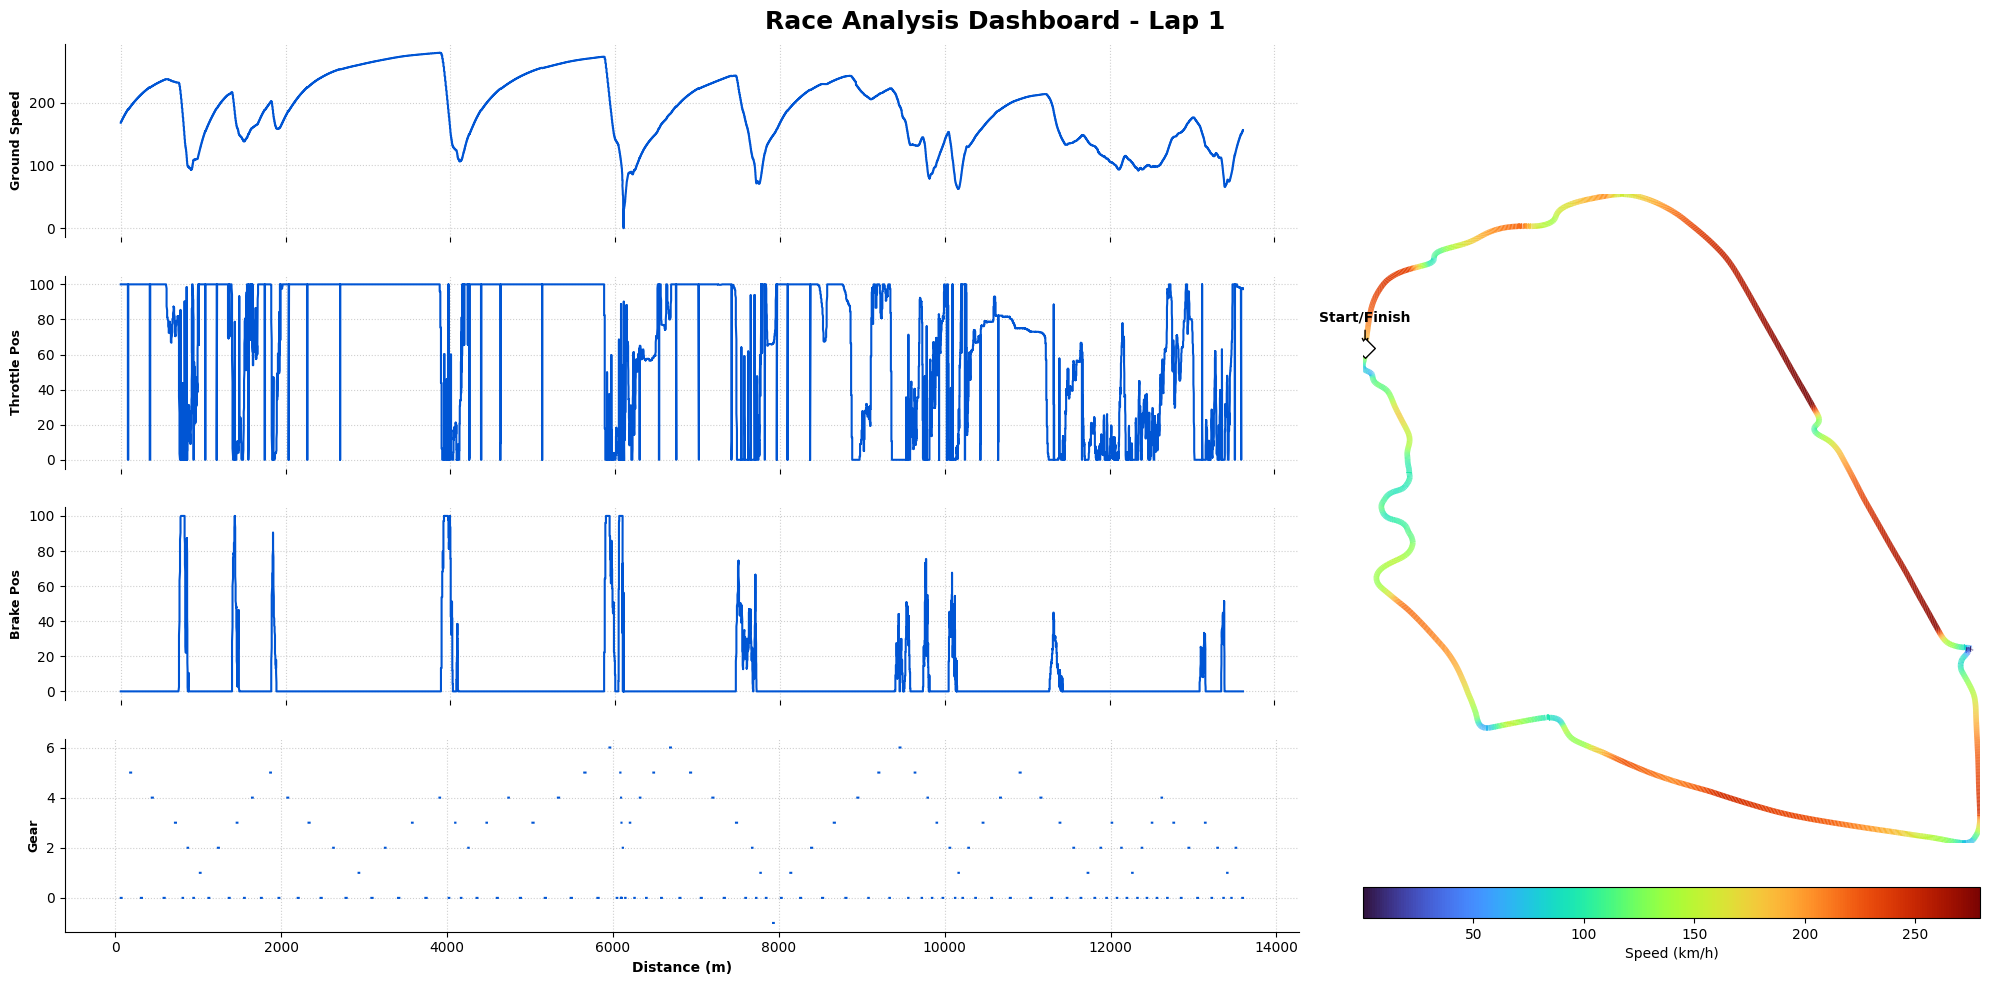

In [369]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import numpy as np

def plot_dashboard_with_start(con, lap_number=1, channels=['Ground Speed', 'Throttle Pos', 'Brake Pos']):
    """
    Generates a dashboard with a Speed-colored Track Map and a marked Start/Finish line.
    """
    
    # 1. Fetch Data
    req_channels = channels + ['GPS Latitude', 'GPS Longitude']
    print(f"Fetching Dashboard Data for Lap {lap_number}...")
    df = get_lap_data_calculated(con, lap_number=lap_number, channels=req_channels)
    
    if df is None or df.empty:
        return

    # 2. Setup Grid
    fig = plt.figure(figsize=(20, 10), facecolor='white')
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
    gs_left = gs[0].subgridspec(len(channels), 1)
    ax_map = fig.add_subplot(gs[1])
    
    color_main = '#0055D4' 
    
    # 3. Plot Telemetry (Left Side)
    for i, channel in enumerate(channels):
        ax = fig.add_subplot(gs_left[i])
        ax.plot(df['Lap Dist'], df[channel], color=color_main, linewidth=1.5)
        ax.set_ylabel(channel, fontweight='bold', fontsize=9)
        ax.grid(True, linestyle=':', alpha=0.6)
        
        # Formatting
        if i == len(channels) - 1:
            ax.set_xlabel('Distance (m)', fontweight='bold')
        else:
            ax.set_xticklabels([])
            ax.spines['bottom'].set_visible(False)
        
        # Clean borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # 4. Plot Track Map (Right Side)
    x = df['GPS Longitude'].values
    y = df['GPS Latitude'].values
    speed = df['Ground Speed'].values 
    
    # Create Line Collection for Heatmap
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = Normalize(vmin=speed.min(), vmax=speed.max())
    lc = LineCollection(segments, cmap='turbo', norm=norm)
    lc.set_array(speed)
    lc.set_linewidth(4) # Thicker line for better visibility
    
    line = ax_map.add_collection(lc)
    ax_map.set_xlim(x.min(), x.max())
    ax_map.set_ylim(y.min(), y.max())
    ax_map.set_aspect('equal')
    ax_map.axis('off') # Remove box around map
    
    # ---------------------------------------------------------
    # NEW: Mark the Start/Finish Line
    # ---------------------------------------------------------
    # The first row of the DF is the start of the lap
    start_x = df.iloc[0]['GPS Longitude']
    start_y = df.iloc[0]['GPS Latitude']
    
    # 1. Plot a Marker (White Diamond with Black outline)
    ax_map.scatter(start_x, start_y, color='white', edgecolor='black', s=100, zorder=10, marker='D', label='Start/Finish')
    
    # 2. Add an Arrow/Text annotation
    ax_map.annotate('Start/Finish', 
                    xy=(start_x, start_y), 
                    xytext=(start_x, start_y + 0.002), # Slightly offset the text
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    fontsize=10, fontweight='bold', ha='center')

    # Add Colorbar
    cbar = plt.colorbar(line, ax=ax_map, orientation='horizontal', pad=0.05, fraction=0.05)
    cbar.set_label('Speed (km/h)')
    
    plt.suptitle(f"Race Analysis Dashboard - Lap {lap_number}", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run
plot_dashboard_with_start(con, lap_number=1, channels=['Ground Speed', 'Throttle Pos', 'Brake Pos', 'Gear'])

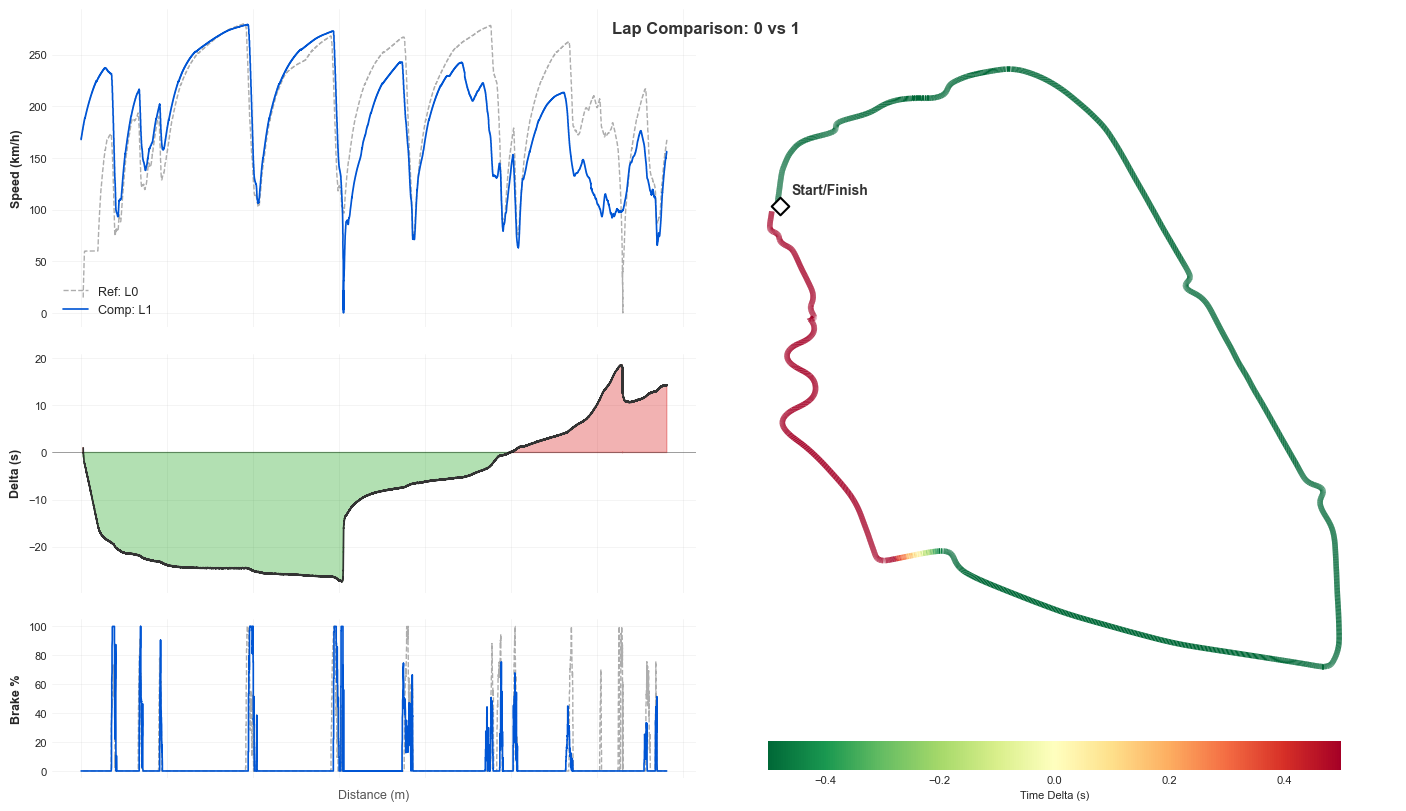

In [375]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import pandas as pd

# Use a clean style
plt.style.use('seaborn-v0_8-whitegrid')

def plot_dashboard_delta_focused(con, laps=[1, 2]):
    """
    A dashboard focused on Time Delta analysis with a properly padded map.
    """
    ref_lap, comp_lap = laps[0], laps[1]
    
    # ---------------------------------------------------------
    # 1. Fetch Data
    # ---------------------------------------------------------
    fetch_channels = ['Ground Speed', 'Brake Pos', 'GPS Latitude', 'GPS Longitude']
    
    df_ref = get_lap_data_calculated(con, lap_number=ref_lap, channels=fetch_channels)
    df_comp = get_lap_data_calculated(con, lap_number=comp_lap, channels=fetch_channels)
    
    if df_ref is None or df_comp is None:
        print("Data fetch failed.")
        return

    # ---------------------------------------------------------
    # 2. Calculate Delta
    # ---------------------------------------------------------
    delta_df = calculate_time_delta(df_ref, df_comp)
    df_ref['Delta'] = delta_df['Delta']

    # ---------------------------------------------------------
    # 3. Setup Grid
    # ---------------------------------------------------------
    fig = plt.figure(figsize=(14, 8), facecolor='white', constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1]) 
    
    gs_left = gs[0].subgridspec(3, 1, height_ratios=[2, 1.5, 1], hspace=0.1)
    ax_map = fig.add_subplot(gs[1])
    
    # Styles
    style_ref = {'color': '#999999', 'linestyle': '--', 'linewidth': 1.0, 'alpha': 0.8, 'label': f"Ref: L{ref_lap}"}
    style_comp = {'color': '#0055D4', 'linestyle': '-', 'linewidth': 1.2, 'alpha': 1.0, 'label': f"Comp: L{comp_lap}"}

    # ---------------------------------------------------------
    # 4. Plot Telemetry (Left Side)
    # ---------------------------------------------------------
    
    # --- CHART 1: SPEED ---
    ax_speed = fig.add_subplot(gs_left[0])
    ax_speed.plot(df_ref['Lap Dist'], df_ref['Ground Speed'], **style_ref)
    ax_speed.plot(df_comp['Lap Dist'], df_comp['Ground Speed'], **style_comp)
    ax_speed.set_ylabel("Speed (km/h)", fontsize=9, fontweight='600')
    ax_speed.legend(loc='lower left', frameon=False, fontsize=9)
    ax_speed.set_xticklabels([])
    
    # --- CHART 2: DELTA ---
    ax_delta = fig.add_subplot(gs_left[1], sharex=ax_speed)
    ax_delta.plot(df_ref['Lap Dist'], df_ref['Delta'], color='#333333', linewidth=1.2)
    ax_delta.fill_between(df_ref['Lap Dist'], df_ref['Delta'], 0, where=(df_ref['Delta'] < 0), color='#009900', alpha=0.3, interpolate=True)
    ax_delta.fill_between(df_ref['Lap Dist'], df_ref['Delta'], 0, where=(df_ref['Delta'] >= 0), color='#D40000', alpha=0.3, interpolate=True)
    ax_delta.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    ax_delta.set_ylabel("Delta (s)", fontsize=9, fontweight='600')
    ax_delta.set_xticklabels([])

    # --- CHART 3: BRAKE ---
    ax_brake = fig.add_subplot(gs_left[2], sharex=ax_speed)
    ax_brake.plot(df_ref['Lap Dist'], df_ref['Brake Pos'], **style_ref)
    ax_brake.plot(df_comp['Lap Dist'], df_comp['Brake Pos'], **style_comp)
    ax_brake.set_ylabel("Brake %", fontsize=9, fontweight='600')
    ax_brake.set_xlabel("Distance (m)", fontsize=9, color='#555')

    for ax in [ax_speed, ax_delta, ax_brake]:
        ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.3)
        ax.tick_params(axis='both', labelsize=8, length=0)
        for spine in ax.spines.values(): spine.set_visible(False)

    # ---------------------------------------------------------
    # 5. Plot Map (Right Side) with PADDING
    # ---------------------------------------------------------
    x, y = df_ref['GPS Longitude'].values, df_ref['GPS Latitude'].values
    delta_vals = df_ref['Delta'].fillna(0).values 
    
    # Segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Color Norm
    max_dev = max(abs(delta_vals.min()), abs(delta_vals.max()))
    limit = min(max_dev, 0.5) 
    norm = TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)
    
    lc = LineCollection(segments, cmap='RdYlGn_r', norm=norm)
    lc.set_array(delta_vals)
    lc.set_linewidth(4)
    
    ax_map.add_collection(lc)
    
    # --- PADDING LOGIC ---
    # Calculate the bounding box of the track
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    # Calculate dimensions
    width = x_max - x_min
    height = y_max - y_min
    
    # Add 10% padding to each side
    padding = 0.1 
    ax_map.set_xlim(x_min - width * padding, x_max + width * padding)
    ax_map.set_ylim(y_min - height * padding, y_max + height * padding)
    
    ax_map.set_aspect('equal')
    ax_map.axis('off')
    
    # --- Start/Finish Marker ---
    # Plotting it slightly larger (s=80) and on top (zorder=20)
    ax_map.scatter(x[0], y[0], color='white', edgecolor='black', s=80, marker='D', zorder=20, linewidth=1.5)
    
    # Annotate with offset
    # We add a slight offset to the text based on the track scale
    text_offset_x = width * 0.02 
    text_offset_y = height * 0.02
    ax_map.text(x[0] + text_offset_x, y[0] + text_offset_y, 'Start/Finish', 
                fontsize=10, fontweight='bold', color='#333', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

    # Colorbar
    cbar = plt.colorbar(lc, ax=ax_map, orientation='horizontal', pad=0.02, fraction=0.04)
    cbar.set_label('Time Delta (s)', fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    cbar.outline.set_visible(False)

    plt.suptitle(f"Lap Comparison: {ref_lap} vs {comp_lap}", fontsize=12, fontweight='bold', y=0.98, color='#333')
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
plot_dashboard_delta_focused(con, laps=[0, 1])